## CPS Charter School Project

In this project I'll use some data available on Chicago public schools to understand how top-performing charter high schools are geographically distributed throughout the city.  Since proximity is a major factor in selecting a school, it might be the case that the current distribution of top-performing high schools puts additional constraints on Chicago families' school choices.

First, let's collect and read in some data from the City of Chicago's open portal.

In [1]:
import pandas as pd
import numpy as np

files = ['/Users/trevornyman/downloads/Chicago_Public_Schools_-_School_Profile_Information_SY1617.csv', 
         '/Users/trevornyman/downloads/Chicago_Public_Schools_-_School_Progress_Reports_SY1516.csv']

#initialize a dictionary that will, eventually, include the file name for the key and the file as dataframe as the value
data = {}

#loop through the files I've downloaded
for f in files:
    
    #assign to variable the file read in as a data frame
    d = pd.read_csv(f)
    
    #add the data frame, d, as the value of the dictionary with the file name minus the ".csv" as the key.
    data[f.replace(".csv", "")] = d
    

#loop through the dictionary containing all the dataframes
for k,v in data.items():
    
    #print the key (less the beginning portion of the path)
    print("\n" + k.replace("/Users/trevornyman/downloads/", "") + "\n")
    
    #print the head of the dataframes
    print(v.head())


Chicago_Public_Schools_-_School_Progress_Reports_SY1516

   School_ID                 Short_Name  \
0     400009         GLOBAL CITIZENSHIP   
1     400010                ACE TECH HS   
2     400011                    LOCKE A   
3     400013  ASPIRA - EARLY COLLEGE HS   
4     400017            ASPIRA - HAUGAN   

                                           Long_Name School_Type  \
0      Academy for Global Citizenship Charter School     Charter   
1                       ACE Technical Charter School     Charter   
2                         Alain Locke Charter School     Charter   
3  ASPIRA Charter School - Early College High School     Charter   
4       ASPIRA Charter School - Haugan Middle School     Charter   

  Primary_Category              Address     City     State    Zip  \
0               ES       4647 W 47TH ST  Chicago  Illinois  60632   
1               HS      5410 S STATE ST  Chicago  Illinois  60609   
2               ES  3141 W JACKSON BLVD  Chicago  Illinois  60612  

I pulled in two data sets, one with profile info on each school, and the second is the most recent progress report available, SY 15/16.  

## Combine the data sets

Now we'll combine the two data sets into one which will make for easier analysis.  To do this, we'll exploit that each data set includes a School_ID column, which acts as a unique identifier for each CPS school.

In [2]:

flat_data_names = [k for k,v in data.items()]
flat_data = [data[k] for k in flat_data_names]
full = flat_data[0]
for i, f in enumerate(flat_data[1:]):
    name = flat_data_names[i+1]
    print(name)
    print(len(f["School_ID"]) - len(f["School_ID"].unique()))
    join_type = "inner"
    #if name in ["sat_results", "ap_2010", "graduation"]:
        #join_type = "outer"
    #if name not in ["math_test_results"]:
    full = full.merge(f, on="School_ID", how=join_type)

full.shape
print ("Number of CPS schools:", len(full))

/Users/trevornyman/downloads/Chicago_Public_Schools_-_School_Profile_Information_SY1617
0
Number of CPS schools: 670


We can see from the above print statement that our dataframe includes information on 670 CPS schools.  Here is a list of all the columns in our full dataframe.  As you can see, we've got a lot from which to choose; around 240 columns.

In [3]:
print (list(full.columns.values))

['School_ID', 'Short_Name_x', 'Long_Name_x', 'School_Type_x', 'Primary_Category_x', 'Address_x', 'City_x', 'State_x', 'Zip_x', 'Phone_x', 'Fax_x', 'CPS_School_Profile_x', 'Website_x', 'Progress_Report_Year', 'Blue_Ribbon_Award_Year', 'Excelerate_Award_Gold_Year', 'Spot_Light_Award_Year', 'Improvement_Award_Year', 'Excellence_Award_Year', 'Student_Growth_Rating', 'Student_Growth_Description', 'Growth_Reading_Grades_Tested_Pct_ES', 'Growth_Reading_Grades_Tested_Label_ES', 'Growth_Math_Grades_Tested_Pct_ES', 'Growth_Math_Grades_Tested_Label_ES', 'Student_Attainment_Rating', 'Student_Attainment_Description', 'Attainment_Reading_Pct_ES', 'Attainment_Reading_Lbl_ES', 'Attainment_Math_Pct_ES', 'Attainment_Math_Lbl_ES', 'Culture_Climate_Rating', 'Culture_Climate_Description', 'School_Survey_Student_Response_Rate_Pct', 'School_Survey_Student_Response_Rate_Avg_Pct', 'School_Survey_Teacher_Response_Rate_Pct', 'School_Survey_Teacher_Response_Rate_Avg_Pct', 'Healthy_School_Certification', 'Healthy_

## Defining "top-performing"

It will be valuable to select a range of valuables from which to calculate a score relative to which a school can perform better or worse.  It will help to rely on only numerical values.  Since not every performance variable will be available for every type of school (e.g., only high schools will have SAT scores, at least with any regularity), let's begin by restricting the scope of our project to high schools.  To do this, we'll define a new data frame, subsetting the full frame for high schools.

Below the .head() print out we see that of the 670 schools in CPS, 188 of them are high schools.

In [4]:
full_HS = full[full['Primary_Category_x'] == 'HS']

print (full_HS.head())
print ("\n", "Number of high schools in CPS:", len(full_HS))

    School_ID               Short_Name_x  \
1      400010                ACE TECH HS   
3      400013  ASPIRA - EARLY COLLEGE HS   
6      400022            CHICAGO ARTS HS   
16     400032          CICS - ELLISON HS   
17     400033            CICS - LONGWOOD   

                                          Long_Name_x School_Type_x  \
1                        ACE Technical Charter School       Charter   
3   ASPIRA Charter School - Early College High School       Charter   
6                    Chicago High School for the Arts      Contract   
16                               CICS - Ralph Ellison       Charter   
17                                    CICS - Longwood       Charter   

   Primary_Category_x            Address_x   City_x   State_x  Zip_x  \
1                  HS      5410 S STATE ST  Chicago  Illinois  60609   
3                  HS     3986 W BARRY AVE  Chicago  Illinois  60618   
6                  HS  2714 W AUGUSTA BLVD  Chicago  Illinois  60622   
16                 H

Which performance variable should we use to calculate a high school's overall performance score?  In the real world, this decision would require substantial discussion among the relevant parties, and would likely be controversial.  For simplicity, I'll include the following variables.  I've also included the range for each variable (for scaling purposes later), and whether that variable includes any missing values we'll need to address.

Performace metrics that we'll include:

'Growth_ACT_Grade_11_Pct' from 2-96, several missing values
'Attainment_ACT_Grade_11_Pct' from 3-99, smv
'Freshmen_On_Track_School_Pct_Year_2' 41.7-100, smv
'Freshmen_On_Track_School_Pct_Year_1' 51.4 - 100, smv
'College_Enrollment_School_Pct_Year_2' 0-92.2, smv
'College_Enrollment_School_Pct_Year_1' 0-89.9, smv
'College_Persistence_School_Pct_Year_2' 14.3-95.7, smv
'College_Persistence_School_Pct_Year_1'25-95.7, smv
'Average_ACT_School' 12.5-29.6, smv
'College_Enrollment_Rate_School' 0 - 93.4, smv
'Graduation_Rate_School' 0 - 97.8, smv

## Cleaning our Data

Two things to note about these variables.  First, for each, many rows are missing values, so we'll need to figure out a way to address this either by leaving them as they are, excluding those rows from our analysis, or imputing them.  

Second, since all but average_ACT are on a 100-pt scale, the variables will need to be scaled in order to come up with a total score.  Otherwise, the variables on the 100-pt scale would have a dispropotionately large weighting in our total performance measure.  (Comment: It's unclear how important this step is in this particular case since 9 of our 10 performance variables *are* on the 100-pt scale; the ACT score is such a small portion of our total metric (only 10%) that its getting swamped by the other variables may not be that big of a deal.)  

Since such a large portion of our data is missing values, we don't want to exclude these rows from our analysis.  So, let's impute the missing values first.  For each variable with missing values, we'll fill in each missing value with the mean score for that variable, though, as with the decision about which variables to include in the total performance score, this decision is potentially controversial and should involve some thought/discussion.

In [5]:
Performance_metrics = ['Growth_ACT_Grade_11_Pct', 
                       'Attainment_ACT_Grade_11_Pct', 
                       'Freshmen_On_Track_School_Pct_Year_2',  
                       'College_Enrollment_School_Pct_Year_2', 
                       'College_Enrollment_School_Pct_Year_1', 
                       'College_Persistence_School_Pct_Year_2', 
                       'College_Persistence_School_Pct_Year_1', 
                       'Average_ACT_School' , 
                       'College_Enrollment_Rate_School', 
                       'Graduation_Rate_School']



#print (full_HS['Growth_ACT_Grade_11_Pct'])
#loop through the variables that go into the total score
for m in Performance_metrics:
    
    #set the values of those variables to themselves with NaN imputed with their mean value.
    full_HS[m] = full_HS[m].fillna(full_HS[m].mean())
    print (full_HS[m])




1      13.000000
3      54.000000
6      70.000000
16     24.000000
17     18.000000
18     66.000000
19     96.000000
20     76.000000
21     34.761905
32     34.000000
33     42.000000
34     38.000000
35     38.000000
36     24.000000
37     46.000000
38     70.000000
39     30.000000
40     24.000000
42     18.000000
43     21.000000
44     58.000000
45     18.000000
48     34.761905
53     46.000000
61     62.000000
62     50.000000
63     34.000000
65     13.000000
67     38.000000
69     58.000000
         ...    
619    58.000000
620    30.000000
622    54.000000
624    13.000000
627    15.000000
628    24.000000
630    13.000000
634    38.000000
635    34.000000
643    34.000000
645    30.000000
647    34.761905
648    13.000000
649    38.000000
651    34.761905
652    34.761905
653    34.761905
654     4.000000
655     2.000000
656    34.761905
657    34.761905
658    34.761905
659     8.000000
660    34.761905
662    34.761905
663    34.761905
664    34.761905
665    34.7619

/Users/trevornyman/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1      61.800000
3      62.900000
6      84.800000
16     70.500000
17     58.800000
18     75.800000
19     84.600000
20     62.500000
21     60.783077
32     65.500000
33     73.100000
34     70.700000
35     64.500000
36     72.000000
37     68.700000
38     84.600000
39     52.300000
40     60.900000
42     66.700000
43     59.600000
44     61.800000
45     65.600000
48     60.783077
53     80.000000
61     67.800000
62     68.100000
63     70.000000
65     61.100000
67     70.600000
69     74.600000
         ...    
619    76.700000
620    50.000000
622    65.300000
624    28.600000
627    48.900000
628    60.500000
630    54.500000
634    71.900000
635    71.400000
643    60.783077
645    60.783077
647    60.783077
648    42.100000
649    60.783077
651    60.783077
652    60.783077
653    60.783077
654    60.783077
655    60.783077
656    60.783077
657    60.783077
658    60.783077
659    60.783077
660    60.783077
662    60.783077
663    60.783077
664    60.783077
665    60.7830

Ok, so the values have been imputed.  For example, if you look at Growth_ACT_Grade_11_Pct, you notice that 34.761905 comes up pretty frequently; obviously, this is the mean value that was imputed for the missing values on these rows.  

Now, we need to scale the data.

In [6]:
def featureScaling(arr):
    new_data= []
    for i in arr:
        new_data.append(float((i-min(arr)))/float(max(arr)-min(arr)))
    return new_data
    

for m in Performance_metrics:
    full_HS[m] = featureScaling(full_HS[m])
    #print (full_HS[m])

/Users/trevornyman/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Let's use the .head() function to take a look at the scaled versions of these variables.

In [7]:
for m in Performance_metrics:
    print (full_HS[m].head())

1     0.117021
3     0.553191
6     0.723404
16    0.234043
17    0.170213
Name: Growth_ACT_Grade_11_Pct, dtype: float64
1     0.052083
3     0.197917
6     0.437500
16    0.093750
17    0.083333
Name: Attainment_ACT_Grade_11_Pct, dtype: float64
1     0.214408
3     0.562607
6     0.751286
16    0.560892
17    0.879931
Name: Freshmen_On_Track_School_Pct_Year_2, dtype: float64
1     0.535792
3     0.436009
6     0.901302
16    0.744035
17    0.779826
Name: College_Enrollment_School_Pct_Year_2, dtype: float64
1     0.577308
3     0.794216
6     0.793103
16    0.836485
17    0.640712
Name: College_Enrollment_School_Pct_Year_1, dtype: float64
1     0.583538
3     0.597052
6     0.866093
16    0.690418
17    0.546683
Name: College_Persistence_School_Pct_Year_2, dtype: float64
1     0.404526
3     0.507779
6     0.568815
16    0.483734
17    0.550212
Name: College_Persistence_School_Pct_Year_1, dtype: float64
1     0.157895
3     0.140351
6     0.403509
16    0.222222
17    0.169591
Name: Av

Now we can compute a total score which will be the sum of each of these variables for each school.  Since the total score is the sum of 10 variables, each of which has a maximum value of 1, out total score values should range from 0-10, which, if we look at the below output, it does.

In [8]:
Vars = [full_HS['Growth_ACT_Grade_11_Pct'], 
                       full_HS['Attainment_ACT_Grade_11_Pct'], 
                       full_HS['Freshmen_On_Track_School_Pct_Year_2'],  
                       full_HS['College_Enrollment_School_Pct_Year_2'], 
                       full_HS['College_Enrollment_School_Pct_Year_1'], 
                       full_HS['College_Persistence_School_Pct_Year_2'], 
                       full_HS['College_Persistence_School_Pct_Year_1'], 
                       full_HS['Average_ACT_School'], 
                       full_HS['College_Enrollment_Rate_School'], 
                       full_HS['Graduation_Rate_School']]

full_HS['Total_Performance_Score'] = sum(Vars)
print ("Maximum score:", max(full_HS['Total_Performance_Score']))
print ("Minimun score:", min(full_HS['Total_Performance_Score']))
print ("\n" ,full_HS['Total_Performance_Score'])


Maximum score: 9.66948274962
Minimun score: 2.35956599043

 1      3.948832
3      4.799242
6      7.126505
16     5.357696
17     5.359943
18     7.376502
19     7.355141
20     6.180815
21     3.977440
32     7.430770
33     7.104650
34     6.864374
35     7.187464
36     6.974237
37     6.627619
38     7.911065
39     5.610077
40     4.820003
42     5.037078
43     5.143441
44     6.509458
45     5.491164
48     2.509234
53     6.138141
61     6.404760
62     5.996504
63     5.730411
65     4.670531
67     5.415949
69     7.303990
         ...   
619    5.745708
620    5.308285
622    7.156540
624    3.486547
627    4.473714
628    5.685496
630    3.873787
634    5.782493
635    6.468588
643    5.622754
645    5.533670
647    2.658570
648    2.359566
649    5.103337
651    5.069110
652    5.411300
653    5.148092
654    3.424898
655    3.869753
656    4.610436
657    4.071263
658    4.897130
659    4.048637
660    3.927448
662    5.044994
663    4.489171
664    4.922187
665    4.414

/Users/trevornyman/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Identifying our "top-performers"

Now that we have a total score for each school, we need a way to determine when a school is "top-performing" relative to this measurement.  One simple way to do this is to designate a certain percentile, above which a school counts as "top-performing".  We can use the .describe() function to do this.

A different approach would use a graded color sceme to illustrate relative scoring on a plot.  This would have the advantage including less bias into what counts as top-performing since it doesn't say exactly what that is.  One disadvantage to this approach, though, is that the visualization of the data will require more interpretation.  

For starters, I'll go with the first strategy and choose the top 25% of schools as the top-performers, and then we can readdress things if we think we need to.

In [9]:
print (full_HS['Total_Performance_Score'].describe())

count    188.000000
mean       5.066403
std        1.502275
min        2.359566
25%        3.903054
50%        5.017926
75%        5.788306
max        9.669483
Name: Total_Performance_Score, dtype: float64


Let's define a new categorical variable, Is_top_performer.

In [10]:
list = []
for index, row in full_HS.iterrows():
    if row['Total_Performance_Score'] >= 5.788306:
        list.append(True)
    else:
        list.append(False)

full_HS['Is_top_performer'] = list

print (full_HS.head())

    School_ID               Short_Name_x  \
1      400010                ACE TECH HS   
3      400013  ASPIRA - EARLY COLLEGE HS   
6      400022            CHICAGO ARTS HS   
16     400032          CICS - ELLISON HS   
17     400033            CICS - LONGWOOD   

                                          Long_Name_x School_Type_x  \
1                        ACE Technical Charter School       Charter   
3   ASPIRA Charter School - Early College High School       Charter   
6                    Chicago High School for the Arts      Contract   
16                               CICS - Ralph Ellison       Charter   
17                                    CICS - Longwood       Charter   

   Primary_Category_x            Address_x   City_x   State_x  Zip_x  \
1                  HS      5410 S STATE ST  Chicago  Illinois  60609   
3                  HS     3986 W BARRY AVE  Chicago  Illinois  60618   
6                  HS  2714 W AUGUSTA BLVD  Chicago  Illinois  60622   
16                 H

/Users/trevornyman/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Let's check and see which variables are correlated with Total_Performance_Score

In [11]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
print_full(full_HS.corr()['Total_Performance_Score'])

School_ID                                      4.083889e-02
Zip_x                                         -3.549819e-02
Phone_x                                       -1.114116e-03
Fax_x                                         -1.202313e-02
Progress_Report_Year                                    NaN
Blue_Ribbon_Award_Year                         4.861248e-01
Excelerate_Award_Gold_Year                              NaN
Spot_Light_Award_Year                                   NaN
Improvement_Award_Year                        -2.655840e-02
Excellence_Award_Year                                   NaN
Growth_Reading_Grades_Tested_Pct_ES            5.263717e-01
Growth_Math_Grades_Tested_Pct_ES               5.593758e-01
Attainment_Reading_Pct_ES                      5.785623e-01
Attainment_Math_Pct_ES                         6.581471e-01
School_Survey_Student_Response_Rate_Pct        2.836467e-01
School_Survey_Student_Response_Rate_Avg_Pct   -4.449825e-16
School_Survey_Teacher_Response_Rate_Pct 

Excluding the variables we used to define Total_Performance_Score, the following variables are correlated (+/-) with TPS .7 or higher: Mobility_Rate_Pct (-).  Though, only about half of the high schools have a value for this variable, and only a quarter of charter high schools include this value.

## Where are the "top-performers" located?

Now let's map our schools.  Here's a heatmap of top-performing high schools in the city of chicago.

In [12]:
import folium
from folium import plugins

schools_heatmap = folium.Map(location=[full_HS['School_Latitude_x'].mean(), full_HS['School_Longitude_x'].mean()], zoom_start=10)
schools_heatmap.add_children(plugins.HeatMap([[row["School_Latitude_x"], row["School_Longitude_x"]] for name, row in full_HS[full_HS['Is_top_performer'] == True].iterrows()]))
schools_heatmap.save("heatmap.html")
schools_heatmap

Here's a regular map.

In [13]:
schools_map = folium.Map(location=[full_HS['School_Latitude_x'].mean(), full_HS['School_Longitude_x'].mean()], zoom_start=10)
marker_cluster = folium.MarkerCluster().add_to(schools_map)
for name, row in full_HS[full_HS['Is_top_performer'] == True].iterrows():
    folium.Marker([row["School_Latitude_x"], row["School_Longitude_x"]], popup="{0}: {1}".format(row["School_ID"], row["School_ID"])).add_to(marker_cluster)
schools_map.save('schools.html')
schools_map

A simple analysis reveals that there is a disproportionate number of top-performing high schools north of the loop.

Here's the same visualization, this time with charter schools.

In [14]:
Top_charters = (full_HS[full_HS['Is_top_performer'] == True][full_HS['School_Type_x'] == 'Charter'])

charter_schools_map = folium.Map(location=[full_HS['School_Latitude_x'].mean(), full_HS['School_Longitude_x'].mean()], zoom_start=10)
marker_cluster = folium.MarkerCluster().add_to(charter_schools_map)
for name, row in Top_charters.iterrows():
    folium.Marker([row["School_Latitude_x"], row["School_Longitude_x"]], popup="{0}: {1}".format(row["School_ID"], row["School_ID"])).add_to(marker_cluster)
charter_schools_map.save('schools.html')
charter_schools_map

/Users/trevornyman/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Since what motivated this project were concerns of the geographic distribution of top-performing charter schools in the Chicago Public Schools district, it would be helpful to see the geography of the district, broken into its 13 geographic networks.

In [15]:
#Map showing CPS broken into regions.

## Performance and Demographic information

Here are some of the findings from the 188 high schools in CPS

In [16]:
Top_HS = full_HS[full_HS['Is_top_performer'] == True]


print ("\n", "Top performing high schools in Chicago:", len(Top_HS))
print ("\n","Top performing charter high schools in Chicago:", len(Top_charters))


 Top performing high schools in Chicago: 47

 Top performing charter high schools in Chicago: 17


Another way to look at this data would be to plot lat and lon for each school and then color it by its performance score.  Let's first do that for all high schools in Chicago.  Again, one advantage here is that we don't have to select a threshold above which a school must be to count as a top-performer.

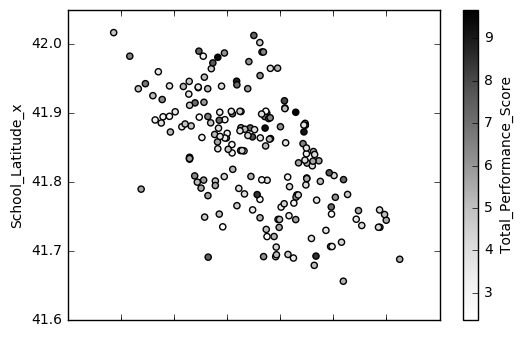

In [17]:
%matplotlib inline

full_HS.plot.scatter(x='School_Longitude_x', y='School_Latitude_x', c='Total_Performance_Score')

And now for charters only.

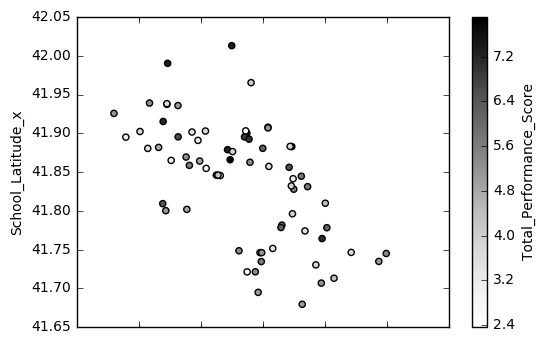

In [18]:
full_HS[full_HS['School_Type_x'] == 'Charter'].plot.scatter(x='School_Longitude_x', y='School_Latitude_x', c='Total_Performance_Score')

These would be more intelligible if they were colored and perhaps limited to three different categories of color corresponding to three different segments of the Total_Performance_Score variable.

Here's a histogram breaking down the frequencies of Total_Performance_Score.

In [19]:
plt.hist(full_HS['Total_Performance_Score'])


NameError: name 'plt' is not defined

We can look at how Total_Performance_Score correlates with a school's demographic information.

Here are some useful variables for these:
'Student_Count_Total', 'Student_Count_Low_Income', 'Student_Count_Special_Ed', 'Student_Count_English_Learners', 'Student_Count_Black', 'Student_Count_Hispanic', 'Student_Count_White', 'Student_Count_Asian', 'Student_Count_Native_American', 'Student_Count_Asian_Pacific_Islander', 'Student_Count_Hawaiian_Pacific_Islander'

Since these are all counts, we'll need to divide them by Student_Count_Total to get the corresponding percentage-variables.

In [ ]:
full_HS['Student_Count_Low_Income_Percentage'] = full['Student_Count_Low_Income']/full['Student_Count_Total']
full_HS['Student_Count_Special_Ed_Percentage'] = full['Student_Count_Special_Ed']/full['Student_Count_Total']
full_HS['Student_Count_English_Learners_Percentage'] = full['Student_Count_English_Learners']/full['Student_Count_Total']
full_HS['Student_Count_Black_Percentage'] = full['Student_Count_Black']/full['Student_Count_Total']
full_HS['Student_Count_Hispanic_Percentage'] = full['Student_Count_Hispanic']/full['Student_Count_Total']
full_HS['Student_Count_White_Percentage'] = full['Student_Count_White']/full['Student_Count_Total']
full_HS['Student_Count_Asian_Percentage'] = full['Student_Count_Asian']/full['Student_Count_Total']
full_HS['Student_Count_Native_American_Percentage'] = full['Student_Count_Native_American']/full['Student_Count_Total']
full_HS['Student_Count_Asian_Pacific_Islander_Percentage'] = full['Student_Count_Asian_Pacific_Islander']/full['Student_Count_Total']
full_HS['Student_Count_Hawaiian_Pacific_Islander_Percentage'] = full['Student_Count_Hawaiian_Pacific_Islander']/full['Student_Count_Total']

print (full_HS['Student_Count_Low_Income_Percentage'].head())
print (full_HS['Student_Count_Special_Ed_Percentage'].head())
print (full_HS['Student_Count_English_Learners_Percentage'].head())
print (full_HS['Student_Count_Black_Percentage'].head())
print (full_HS['Student_Count_Hispanic_Percentage'].head())
print (full_HS['Student_Count_White_Percentage'].head())
print (full_HS['Student_Count_Asian_Percentage'].head())
print (full_HS['Student_Count_Native_American_Percentage'].head())
print (full_HS['Student_Count_Asian_Pacific_Islander_Percentage'].head())
print (full_HS['Student_Count_Hawaiian_Pacific_Islander_Percentage'].head())


Let's do some simple plots correlating demographic info with Total_Performance_Score.  First, with low income percentages.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(full_HS['Student_Count_Low_Income_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

And by percentage of special education students

In [ ]:
plt.plot(full_HS['Student_Count_Special_Ed_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

And by percentage of English language lerners.

In [ ]:
plt.plot(full_HS['Student_Count_English_Learners_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

And by percentage of Black students

In [ ]:
plt.plot(full_HS['Student_Count_Black_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

And by percentage of Hispanic students

In [ ]:
plt.plot(full_HS['Student_Count_Hispanic_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

And by percentage of White students

In [ ]:
plt.plot(full_HS['Student_Count_White_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

And by percentage of Asian students

In [ ]:
plt.plot(full_HS['Student_Count_Asian_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

And by percentage of Native American students

In [ ]:
plt.plot(full_HS['Student_Count_Native_American_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

And by percentage of Asian Pacific Islander students 

In [ ]:
plt.plot(full_HS['Student_Count_Asian_Pacific_Islander_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

And by percentage of Hawaiian Pacific Islander students 

In [ ]:
plt.plot(full_HS['Student_Count_Hawaiian_Pacific_Islander_Percentage'], full_HS['Total_Performance_Score'], 'ro')
plt.axis([0, 1.5, 0, 10])
plt.show()

## Wrapping Up

So, this basically wraps up the project.  We got a nice visualization of how top-performing high schools, and charter high schools are geographically distributed through the city of Chicago.  We also visualized some of the correlations between demographic information and our performance metrics.  The visualizations in addition to answering some of our questions actually lead to more questions, which, I take it, is a hallmark of good analysis.